# 자기지도학습 기반의 대조학습 모델 SimSiam

**지은이:** [Sayak Paul](https://twitter.com/RisingSayak)<br>
**옮긴이:** [Janghoo Lee](https://www.linkedin.com/in/janghoo-lee-25212a1a0/)<br>
**원본노트북:** [Self-supervised contrastive learning with SimSiam](https://keras.io/examples/vision/simsiam/)<br>
**원본작성일:** 2021/03/19<br>
**최종수정일:** 2021/03/20<br>
**번역일:** 2021/10/04<br>
**번역최종수정일:** 2021/10/11<br>
**설명:** 컴퓨터비전 문제를 해결하기 위한 자기지도<sub>self-supervised</sub>학습 방법을 구현해봅니다.

**선행 추천 노트북** <br>

1. 
Eng : [Semi-supervised image classification using contrastive pretraining with SimCLR](https://keras.io/examples/vision/semisupervised_simclr/) <br>
Kor : 준지도학습 기반의 대조적 사전학습 모델 (SimCLR) 을 이용한 이미지 분류
2.
Eng : [Image similarity estimation using a Siamese Network with a contrastive loss](https://keras.io/examples/vision/siamese_contrastive/) <br>

<br>

*이 노트북은 2021 Open Source Contribution Contribution Academy, Keras Korea 의 지원을 받아 제작되었습니다. 한국어로 옮겨진 노트북은 이해를 돕기 위해 원본 노트북에서 제공하는 설명에 대해 추가적인 내용이 들어가 있음을 알립니다. 원문 설명은 [원본 노트북](https://keras.io/examples/vision/simsiam/)을 참고하세요.*

자기지도학습<sub>self-superised learning, SSL</sub> 은 표현학습<sub>representation learning</sub> 과 관련해서 활발하게 회자되는 연구분야 중 하나입니다. 자기지도학습이 해결해야 하는 일의  목표는 레이블링되지 않은 수많은 데이터들로부터, 데이터를 단순하게 표현할 수 있는 적절한  모델을 학습하도록 만드는 것이라고 할 수 있습니다. 표현학습에 대해 더 궁금하다면 [이 블로그](https://ratsgo.github.io/deep%20learning/2017/04/25/representationlearning/) 를 참고하세요.

"아버지가 방에..." 와 같이 어떤 완결되지 않은 한국어 문장이 제공됐을 때, 다음 단어를 예측하는 딥러닝 모델을 학습시키는 시도들을 생각해 봅시다. 이런 모델을 학습시키기 위한 데이터를 만들기 위해 사람이 따로 다음 단어로 어떤 단어가 나와야 하는지 일일히 지정해주지 않을 것입니다. 그 대신, 엔지니어들은 수많은 다른 완결된 문장들을 수집하고, 이들로부터 문장의 일부분을 가려가며, 가려진 부분을 알아맞추도록 학습시킬 것입니다. 이런 부류의 학습 방법들이 자기지도학습에 속합니다. 이렇게 대량으로 미리 준비되어 있는 데이터를 통해 내가 실제로 풀고자 하는 문제를 풀 때, 대량의 데이터와 함께 데이터의 특징과 표현을 미리 학습할 수 있도록 풀어야 하는 과제를 **사전문제**<sub>pretext/auxiliary task</sub> 이라고 하고, 우리가 풀어내야 하는 과제를 **다운스트림문제**<sub>downstream task</sub> 라고 합니다. 만약 당신이 세계의 수많은 지식이 집대성된 위키피디아의 문장들같이 정말 거대한 데이터들을 통해 **사전문제** *(예를 들어, 문장 내 임의의 빈칸을 맞추는 문제)* 를 풀도록 학습시킨다면, 모델은 당신이 풀고자 하는 **다운스트림문제** *(예를 들어, 처음 보는 문장에서 다음으로 나올 단어를 맞추는 문제)* 에까지 긍정적으로 영향을 줄 수 있는 일반적인 표현을 미리 학습해 둘 것이라고 예상할 수 있습니다. BERT, GPT-3, ELMo 같은 유명한 언어모델들은 모두 이런 방식으로 학습됐습니다. <br>

<br>

이미지 데이터셋에 대해서 적절한 표현을 학습시킨다고 할 때, "적절한 표현" 을 학습한 모델이 무엇인가에 대해서는 많은 논의가 있습니다. 괜찮은 내용을 인용해 보자면 다음과 같습니다. 논문 [Contrastive Learning for Label Efficient Semantic Segmentation](https://arxiv.org/abs/2012.06985) 에서는 "적절한 표현을 학습한 모델" 이란 입력 이미지 각각에 대해서 내가 풀고자 하는 다운스트림문제에서 구분해내야 하는 클래스들끼리는 확실히 구분이 잘 되도록<sub>inter-class separability</sub> 투영시킬 수 있는 동시에, 클래스마다 투영되는 공간이 가깝게 붙어있도록<sub>intra-class compactness</sub> 투영시킬 수 있도록 학습된 모델이라고 주장합니다.

하나의 컴퓨터비전과 관련된 예를 더 들어 보겠습니다. 내가 자동차를 감지하는 모델을 만들고자 할 때, 자동차에 대해서 경계 박스를 그려둔 이미지-레이블 쌍은 많이 존재하지 않지만 길에 돌아다니는 자동차 이미지들은 정말 많이 구할 수 있을 것이라고 쉽게 상상할 수 있습니다. ([The Cityscapes Dataset for Semantic Urban Scene Understanding](https://arxiv.org/abs/1604.01685) 을 인용하면, 이미지 한 장에 대해서 정밀한 픽셀 마스크를 만드는 데 평균 1시간 30분이 걸렸다고 합니다.) 자동차에 대한 일반적인 특징을 모델이 레이블 없이도 쉽게 모을 수 있는 많은 이미지들만을 통해 학습할 수 있도록 만들어주어야 합니다. 예를 들어 원본 자동차 이미지에서 랜덤한 영역을 뽑아 노이즈를 만들어내고, 딥러닝 모델이 인위적인 노이즈가 만들어진 부분을 다시 복원해내도록 시키는 태스크가 있다고 생각해 봅시다. 이런 태스크에는 이미지 외 레이블은 필요가 없습니다. 방금 예시에서 "원본 자동차 이미지에서 랜덤 영역을 뽑아 노이즈를 칠하고, 모델이 노이즈를 제거해 깨끗한 이미지를 복원해내도록 만드는" 일을 시킨다고 할 때, 복원하는 이 작업같이 이미지에 대한 적절한 표현을 학습시키기 위한 의도로 수행하는 작업이 바로 사전작업입니다. 사전작업에 대한 연구는 정말 많이 진행되어 왔고 더 많은 정보는 [이 블로그](https://hoya012.github.io/blog/Self-Supervised-Learning-Overview/) 를 참고하세요.

이 노트북에서, 우리는 논문 [Exploring Simple Siamese Representation Learning](https://arxiv.org/abs/2011.10566) 에서 처음 제안된 SimSiam 이라고 불리는 시스템을 구현해 볼 것입니다.

1. 확률적<sub>stochastic</sub> 이미지 증강 파이프라인을 통해 동일한 데이터셋에 대해 두 개의 다른 버전을 생성해냅니다. 예를 들면 이미지 A 에 대해서 10도 회전과 10% 확대가 적용된 A', 이미지 A 에 대해서 13도 회전과 10% 축소가 적용된 A'' 로 구성된 (A',A'') 쌍입니다.
2. 모델의 끝단 분류기 (classification head) 를 가지고있지 않은 ResNet 중추 신경망<sub>backbone</sub>에 완전연결층 (projection heead) 을 붙여서 인코더를 만듭니다.
3. 인코더의 출력을 완전연결층으로 구성된 분류모듈<sub>predictor</sub> 으로 보냅니다.
4. 그리고 우리가 만든 인코더가 1 에서 만들었던 다른 두 버전의 데이터셋에 대해 코사인유사도를 최대화시키도록 학습시킵니다.

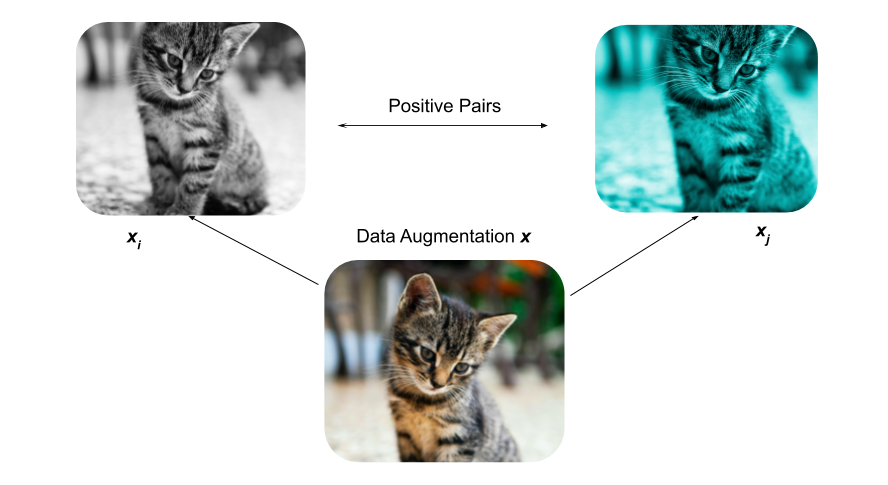 <br>
*Figure by Author. Photo by Edgar on Unsplash*

## 준비

*이 노트북은 TensorFlow 2.4.0 이상의 버전이 필요합니다.*

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow as tf
print(f"tensorflow version : {tf.__version__}")

import matplotlib.pyplot as plt
import numpy as np

tensorflow version : 2.6.0


## 하이퍼파라미터 정의

In [ ]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 128
EPOCHS = 5
CROP_TO = 32
SEED = 26

PROJECT_DIM = 2048
LATENT_DIM = 512
WEIGHT_DECAY = 0.0005

## CIFAR-10 데이터셋 불러오기

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print(f"Total training examples: {len(x_train)}")
print(f"Total test examples: {len(x_test)}")

Total training examples: 50000
Total test examples: 10000


## 데이터 증강 파이프라인 정의하기

적절한 데이터 증강 파이프라인을 구축하는 것이 자기지도학습을 통해 컴퓨터 비전 문제를 풀 때 굉장히 중요하다는 것을 [SimCLR](https://arxiv.org/abs/2002.05709) 논문에서 보여주었습니다. 특히, 랜덤크기변환과 랜덤잘라내기, 색상변형을 통한 이미지데이터 증강이 가장 유의미했습니다. [BYOL](https://arxiv.org/abs/2006.07733),
[MoCoV2](https://arxiv.org/abs/2003.04297), [SwAV](https://arxiv.org/abs/2006.09882) 같은 유명한 논문들이 제안하는 자기지도학습 시스템도 이러한 변형/증강 방법을 훈련 파이프라인에 포함시켰습니다.

In [ ]:
def flip_random_crop(image):
    # 수평방향 뒤집기를 수행합니다.
    image = tf.image.random_flip_left_right(image)
    # 랜덤 자르기를 수행합니다.
    image = tf.image.random_crop(image, (CROP_TO, CROP_TO, 3))
    return image


def color_jitter(x, strength=[0.4, 0.4, 0.4, 0.1]):
    x = tf.image.random_brightness(x, max_delta=0.8 * strength[0])
    x = tf.image.random_contrast(
        x, lower=1 - 0.8 * strength[1], upper=1 + 0.8 * strength[1]
    )
    x = tf.image.random_saturation(
        x, lower=1 - 0.8 * strength[2], upper=1 + 0.8 * strength[2]
    )
    x = tf.image.random_hue(x, max_delta=0.2 * strength[3])
    # 위와 같은 아핀 변환은 RGB 이미지의 [0,255] 범위를 벗어나도록 만듭니다.
    # 따라서 아래 클리핑이라고 불리는 과정이 반드시 수행되어야 합니다.
    x = tf.clip_by_value(x, 0, 255)
    return x


def color_drop(x):
    x = tf.image.rgb_to_grayscale(x)
    x = tf.tile(x, [1, 1, 3])
    return x


def random_apply(func, x, p):
    if tf.random.uniform([], minval=0, maxval=1) < p:
        return func(x)
    else:
        return x


def custom_augment(image):
    # SimCLR 에서 논의되었듯이, 모델(인코더) 는 이미지의 변형에 강인하도록 학습되어야 합니다.
    # 따라서 이미지 변형/증강은 무작위하게 적용되어야 합니다.
    image = flip_random_crop(image)
    image = random_apply(color_jitter, image, p=0.8)
    image = random_apply(color_drop, image, p=0.2)
    return image

이미지 증강 파이프라인은 일반적으로 데이터셋의 특성에 영향을 많이 받는다는 사실을 기억해 두는 것이 좋습니다. 예를 들어, 당신이 다루는 데이터셋에 포함되어 있는 이미지가 객체중심적<sub>object centric</sub> 일 때, 이미지의 중심에 더욱더 가깝게 잘라내어 학습 데이터로 사용한다면 당연히 성능을 떨어뜨릴 수 있습니다. 이제 데이터 증강 파이프라인을 만들고 몇몇 결과물을 시각화해 봅니다.

## 데이터를 TensorFlow `Dataset` 객체로 변환하기

여기서 우리는 정답 레이블이 존재하지 않는 데이터셋을 두 가지 방식으로 변형하는 과정을 담은 데이터셋 객체를 만들 것입니다.

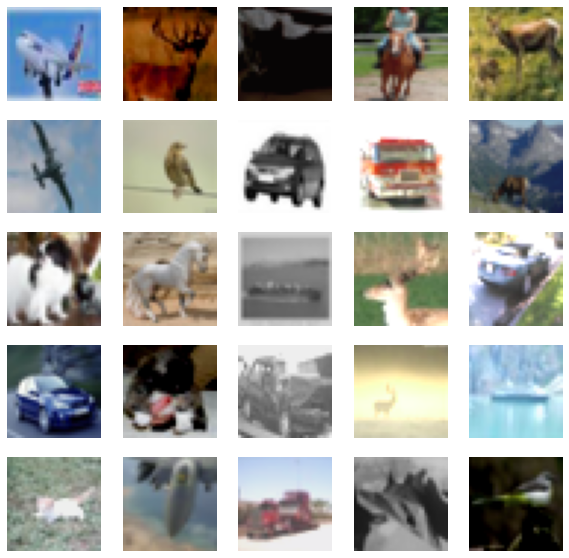

---


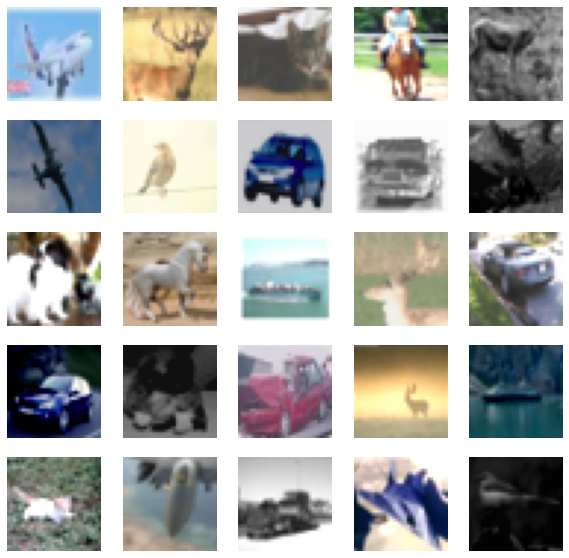

In [ ]:
ssl_ds_one = tf.data.Dataset.from_tensor_slices(x_train)
ssl_ds_one = (
    ssl_ds_one.shuffle(1024, seed=SEED)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

ssl_ds_two = tf.data.Dataset.from_tensor_slices(x_train)
ssl_ds_two = (
    ssl_ds_two.shuffle(1024, seed=SEED)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

ssl_ds = tf.data.Dataset.zip((ssl_ds_one, ssl_ds_two))

# 몇몇 증강된 이미지를 시각화해 봅니다.
sample_images_one = next(iter(ssl_ds_one))
plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(sample_images_one[n].numpy().astype("int"))
    plt.axis("off")
plt.show()

# sample_images_one 과 sample_images_two 가 정확히 
# 이미지들을 "쌍" 으로 가지고 있는지 확인하기 위해 한번 더 검토해 봅시다.
print('---')
sample_images_two = next(iter(ssl_ds_two))
plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(sample_images_two[n].numpy().astype("int"))
    plt.axis("off")
plt.show()

`samples_images_one` 와 `sample_images_two` 은 동일한 이미지들부터 만들어졌지만, 조금씩 다르게 변형되어 다른 모습을 보입니다.

## 인코더와 예측기 모듈 정의

우리는 이 노트북에서 CIFAR10 데이터셋을 처리할 중추 신경망으로 ResNet20 을 사용할 것입니다. 이 코드는 
[keras-idiomatic-programmer](https://github.com/GoogleCloudPlatform/keras-idiomatic-programmer/blob/master/zoo/resnet/resnet_cifar10_v2.py) 저장소로부터 가져와졌습니다. 이 구현체의 하이퍼파라미터는 [이 논문](https://arxiv.org/abs/2011.10566) 의 `Section3` 과 `Appendix A` 를 참고하세요.

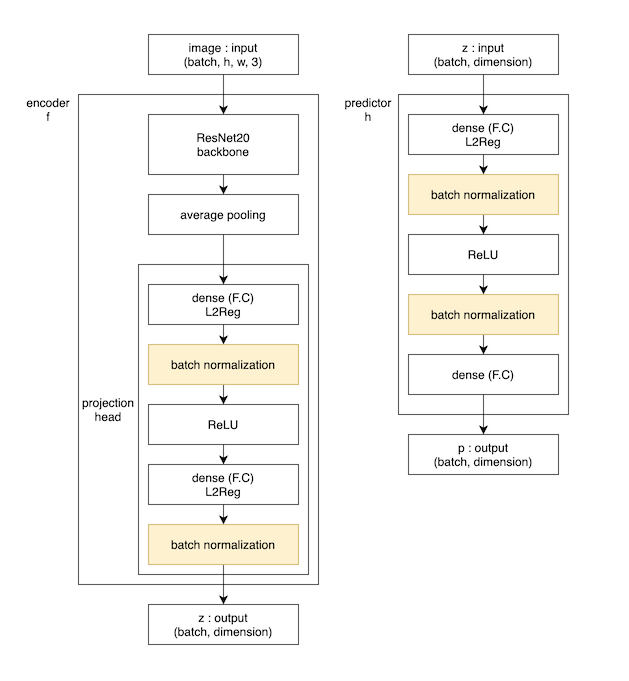

In [ ]:
!wget -q https://git.io/JYx2x -O resnet_cifar10_v2.py

In [ ]:
import resnet_cifar10_v2

N = 2
DEPTH = N * 9 + 2
NUM_BLOCKS = ((DEPTH - 2) // 9) - 1


def get_encoder():

    # 입력, 중추신경망
    inputs = layers.Input((CROP_TO, CROP_TO, 3))
    x = layers.Rescaling(scale=1.0 / 127.5, offset=-1)(
        inputs
    )
    x = resnet_cifar10_v2.stem(x)
    x = resnet_cifar10_v2.learner(x, NUM_BLOCKS)
    x = layers.GlobalAveragePooling2D(name="backbone_pool")(x)

    # 투영 층
    x = layers.Dense(
        PROJECT_DIM, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY)
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dense(
        PROJECT_DIM, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY)
    )(x)
    outputs = layers.BatchNormalization()(x)
    return tf.keras.Model(inputs, outputs, name="encoder")


def get_predictor():
    model = tf.keras.Sequential(
        [
            # 오토인코더와 비슷한 병목 구조입니다.
            layers.Input((PROJECT_DIM,)),
            layers.Dense(
                LATENT_DIM,
                use_bias=False,
                kernel_regularizer=regularizers.l2(WEIGHT_DECAY),
            ),
            layers.ReLU(),
            layers.BatchNormalization(),
            layers.Dense(PROJECT_DIM),
        ],
        name="predictor",
    )
    return model

## 사전학습 루프 정의하기

이런 방식으로 어떤 네트워크를 훈련시키고, 이런 것들을 사전학습<sub>pre-training</sub> 이라고 부르는 가장 주된 이유는, 자기지도학습으로부터 레이블 없이 훈련된 표현으로부터 실제로 풀고자 하는 문제 (다운스트림 문제) 에도 유의미한 영향을 주기 위함입니다. 실제로 내가 궁극적으로 문제를 풀고자 했을 때, 분류에 필요한 레이블이 존재하지 않더라도 분류 문제를 푸는 데 도움을 줄 수 있어야 한다는 이야기입니다.

In [ ]:
def compute_loss(p, z):
    # SimSiam 저자는 'stop_gradient' 연산이 
    # 성능에서 중요한 역할을 한다고 강조합니다.
    z = tf.stop_gradient(z)
    p = tf.math.l2_normalize(p, axis=1)
    z = tf.math.l2_normalize(z, axis=1)
    # 코사인유사도의 음수를 최소화하도록 훈련시킵니다.
    # 즉, 코사인유사도를 최대화하도록 모델을 훈련시킵니다.
    # p, z 의 shape : (배치사이즈, 벡터차원)
    # return shape : 스칼라
    return -tf.reduce_mean(tf.reduce_sum((p * z), axis=1))

We then define our training loop by overriding the `train_step()` function of the
`tf.keras.Model` class.

그리고 우리는 `tf.keras.Model` 클래스의 `train_step()` 메서드를 오버라이딩하여 훈련 루프를 재정의합니다.

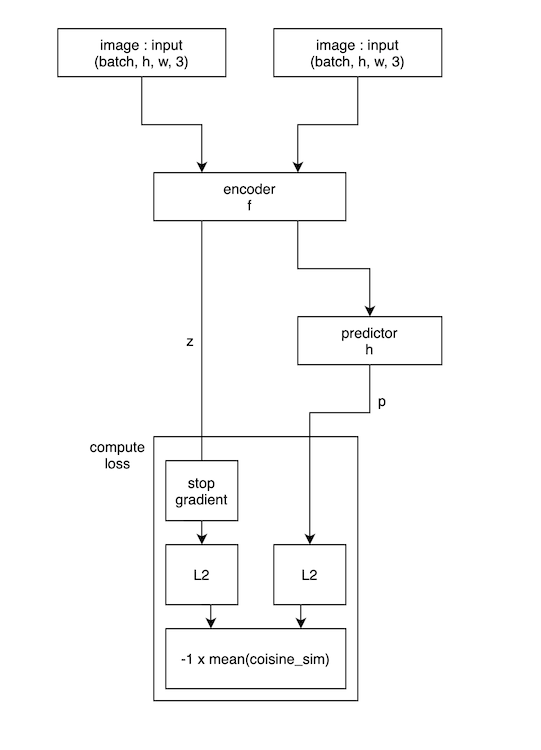

In [ ]:
class SimSiam(tf.keras.Model):
    def __init__(self, encoder, predictor):
        super(SimSiam, self).__init__()
        self.encoder = encoder
        self.predictor = predictor
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        
        # 데이터를 언패킹합니다.
        # 각각은 경로1, 경로2 로 전달될 이미지들에 해당합니다.
        ds_one, ds_two = data

        # 각각의 데이터를 인코더와 예측기로 통과시킵니다.
        with tf.GradientTape() as tape:
            z1, z2 = self.encoder(ds_one), self.encoder(ds_two)
            p1, p2 = self.predictor(z1), self.predictor(z2)
            # 우리가 조금 다르게 생긴 두 이미지에 대해서 동일한 표현을 학습하도록
            # 강제하고 있다는 점을 기억하세요.
            loss = compute_loss(p1, z2) / 2 + compute_loss(p2, z1) / 2

        # 그래디언트를 계산하고 파라미터를 업데이트합니다.
        learnable_params = (
            self.encoder.trainable_variables + self.predictor.trainable_variables
        )
        gradients = tape.gradient(loss, learnable_params)
        self.optimizer.apply_gradients(zip(gradients, learnable_params))

        # 손실을 모니터링합니다.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

## 네트워크 사전학습하기

이 노트북에서는 5에폭만 훈련을 시도해 봅니다. 실제로 SimSiam 에서 제안하는 이와 같은 방식을 풀려는 문제에 제대로 적용하기 위해서는 최소 100에폭 이상을 훈련시켜야 합니다.

In [ ]:
# 학습 스케줄러를 생성합니다.
num_training_samples = len(x_train)
steps = EPOCHS * (num_training_samples // BATCH_SIZE)
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.03, decay_steps=steps
)

# 손실이 더 이상 떨어지지 않을 때 정해진 에폭을 모두 마치지 않아도
# 조기종료되는 콜백을 생성합니다.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="loss", patience=5, restore_best_weights=True
)

# 모델을 컴파일하고 학습을 시작합니다.
simsiam = SimSiam(get_encoder(), get_predictor())
simsiam.compile(optimizer=tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.6))
history = simsiam.fit(ssl_ds, epochs=EPOCHS, callbacks=[early_stopping])

# 모델의 학습 진행 과정을 시각화합니다.
plt.plot(history.history["loss"])
plt.grid()
plt.title("Negative Cosine Similairty")
plt.show()

만약 우리가 만든 어떤 모델이 손실이 가질 수 있는 범위 중 최솟값인 -1 에 엄청 빠르게 수렴한다면, 그것은 표현 붕괴<sub>representation collapse</sub> 문제일 가능성이 높습니다. 이것은 모든 이미지에 대해서 동일한 표현을 만들도록 학습되었기 때문입니다. (조금 더 구체적인 내용은 선행 추천 노트북 1을 참고하세요.) 이렇게 표현 붕괴가 일어난 경우에는, 다음과 같은 방법들을 사용해서 추가적인 초매개변수 미세 조정을 해 보아야 합니다. 이런 시도들이 표현 붕괴가 일어날 가능성을 줄이는 데 도움이 될 수 있기 때문입니다.

1. 색상 변형과 그 확률을 높인다.
2. 학습률을 조절해 본다.
3. 중추 신경망과 투영 층을 확인해 본다.

## 자기지도학습 평가

컴퓨터비전 자기지도학습에서 가장 널리 사용되는 성능 평가방식은, 선형 분류기 층을 가중치가 변화하지 않도록 고정된<sub>frozen</sub> 인코더의 가장 추상화된 부분에 추가적으로 부착한 뒤 (이 노트북에서는 ResNet20 기반의 인코더를 사용합니다.) 아직 모델이 보지 못한 이미지들로 분류기를 학습시키고, 성능을 평가하는 과정으로 이루어집니다.

In [ ]:
# 우선 레이블링된 tf.data.Dataset 객체를 생성합니다.
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# 데이터를 적절히 섞고, 배치를 만들어 줍니다. 
# 데이터 로드속도를 높이기 위해 프리페치(prefetch) 하는 것을 잊지 맙시다.
# 랜덤 크기조절, 랜덤 잘라내기 또한 사용하되, 훈련 데이터셋에만 사용합니다.
train_ds = (
    train_ds.shuffle(1024)
    .map(lambda x, y: (flip_random_crop(x), y), num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

# ResNet20 중추 모델을 가져옵니다.
backbone = tf.keras.Model(
    simsiam.encoder.input, simsiam.encoder.get_layer("backbone_pool").output
)

# 선형 분류기를 부착합니다.
backbone.trainable = False
inputs = layers.Input((CROP_TO, CROP_TO, 3))
x = backbone(inputs, training=False)
outputs = layers.Dense(10, activation="softmax")(x)
linear_model = tf.keras.Model(inputs, outputs, name="linear_model")

# 모델을 컴파일하고 학습을 시작합니다.
linear_model.compile(
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
    optimizer=tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.9),
)
history = linear_model.fit(
    train_ds, validation_data=test_ds, epochs=EPOCHS, callbacks=[early_stopping]
)
_, test_acc = linear_model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

## 참고

- 일반적으로 더 많은 데이터와 더 긴 사전학습은 자기지도학습에 긍정적인 영향을 준다고 알려져 있습니다.
- 자기지도학습은 특히 우리가 가지고 있는 레이블링되어 있는 데이터셋이 제한되어 있지만, 거대한 양의 레이블링되지 않은 데이터를 수집하고 관리할 능력이 있을 때 유용합니다. 최근 Facebook 에서는 [SwAV](https://arxiv.org/abs/2006.09882) 이라는 자기지도학습 방법론을 통해 [RegNet](https://arxiv.org/abs/2006.09882) 을 중추 신경망으로 하여 2억개의 레이블링되지 않은 데이터셋을 학습했습니다. Facebook 은 자기지도학습과 지도학습을 섞어 사용함으로써 지도학습으로만 학습했던 신경망보다 더 좋은 성능을 내는 결과를 얻어내는 데 성공했습니다. 몇몇 다운스트림 문제에서는 지도학습이 세워 두었던 기록들을 갱신하기도 했습니다. [논문 Self-supervised Pretraining of Visual Features in the Wild](https://arxiv.org/pdf/2103.01988.pdf) 을 통해 더 자세히 알아보세요.
- 만약 왜 자기지도학습이 유의미한 표현을 학습하는 데 도움이 되는지 궁금하다면, 다음 자료들을 참고하면 좋습니다.
   * [Self-supervised learning: The dark matter of
intelligence](https://ai.facebook.com/blog/self-supervised-learning-the-dark-matter-of-intelligence/)
   * [Understanding self-supervised learning using controlled datasets with known
structure](https://sslneuips20.github.io/files/CameraReadys%203-77/64/CameraReady/Understanding_self_supervised_learning.pdf) (지금은 볼 수 없습니다.)